# Example Interrupted Time Series (ITS) with `pymc` models

This notebook shows an example of using interrupted time series, where we do not have untreated control units of a similar nature to the treated unit and we just have a single time series of observations and the predictor variables are simply time and month.

In [1]:
import arviz as az
import pandas as pd

import causalpy as cp

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

## Interrupted Time Series (ITS) Example

Load data

In [3]:
df = (
    cp.load_data("its")
    .assign(date=lambda x: pd.to_datetime(x["date"]))
    .set_index("date")
)

treatment_time = pd.to_datetime("2017-01-01")
df.head()

,month,year,t,y
date,,,,
2010-01-31,1,2010,0,25.058186
2010-02-28,2,2010,1,27.189812
2010-03-31,3,2010,2,26.487551
2010-04-30,4,2010,3,31.241716
2010-05-31,5,2010,4,40.753973


Run the analysis

:::{note}
The `random_seed` keyword argument for the PyMC sampler is not neccessary. We use it here so that the results are reproducible.
:::

In [4]:
result = cp.pymc_experiments.InterruptedTimeSeries(
    df,
    treatment_time,
    formula="y ~ 1 + t + C(month)",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


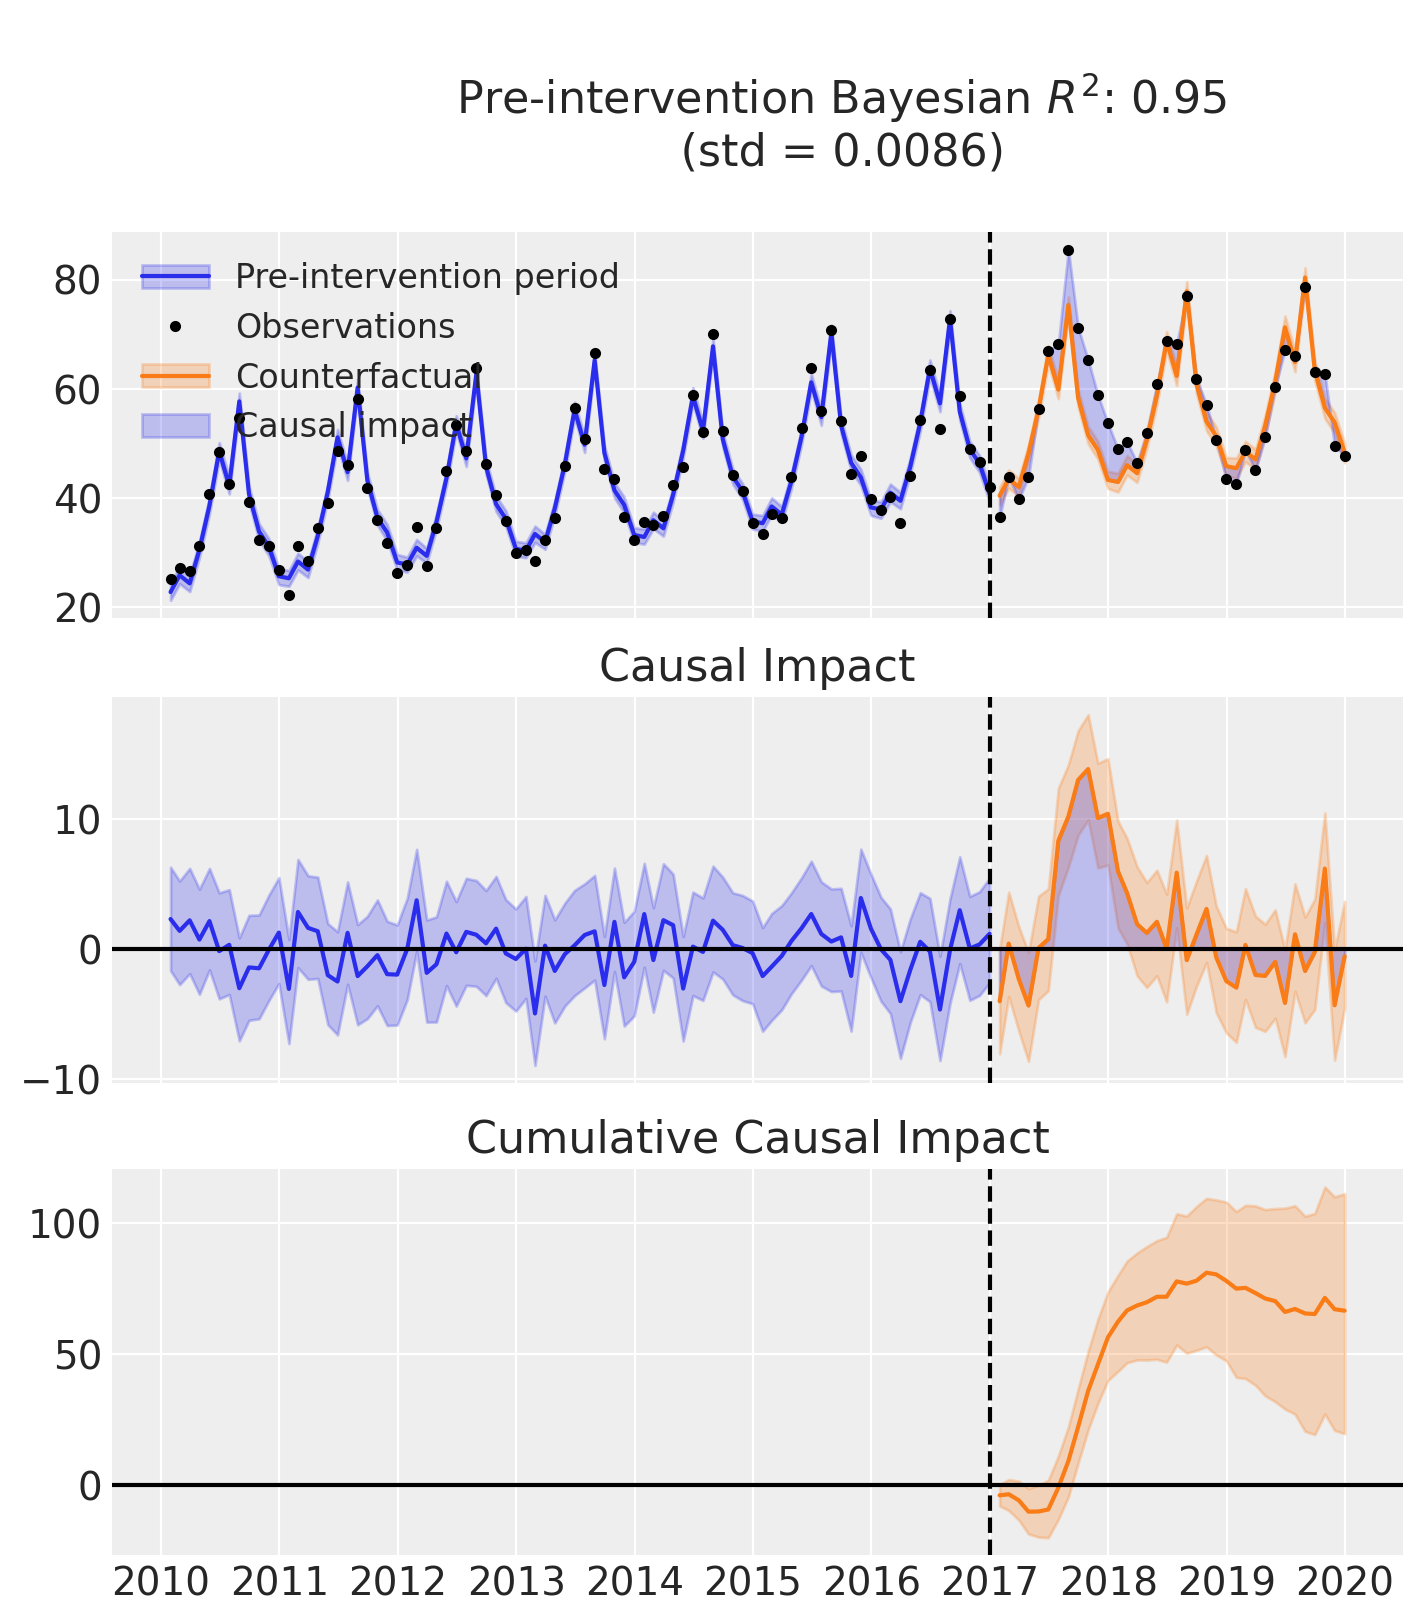

In [5]:
fig, ax = result.plot()

In [6]:
result.summary()

==================================Pre-Post Fit==================================
Formula: y ~ 1 + t + C(month)
Model coefficients:
    Intercept       23, 94% HDI [21, 24]
    C(month)[T.2]   2.9, 94% HDI [0.88, 4.8]
    C(month)[T.3]   1.2, 94% HDI [-0.81, 3.1]
    C(month)[T.4]   7.1, 94% HDI [5.2, 9.1]
    C(month)[T.5]   15, 94% HDI [13, 17]
    C(month)[T.6]   25, 94% HDI [23, 27]
    C(month)[T.7]   18, 94% HDI [16, 20]
    C(month)[T.8]   33, 94% HDI [32, 35]
    C(month)[T.9]   16, 94% HDI [14, 18]
    C(month)[T.10]  9.2, 94% HDI [7.2, 11]
    C(month)[T.11]  6.3, 94% HDI [4.2, 8.2]
    C(month)[T.12]  0.59, 94% HDI [-1.4, 2.5]
    t               0.21, 94% HDI [0.19, 0.23]
    sigma           2, 94% HDI [1.7, 2.3]


As well as the model coefficients, we might be interested in the avarage causal impact and average cumulative causal impact.

:::{note}
Better output for the summary statistics are in progress!
:::

First we ask for summary statistics of the causal impact over the entire post-intervention period.

In [7]:
az.summary(result.post_impact.mean("obs_ind"))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,1.845,0.677,0.542,3.086,0.013,0.009,2631.0,3110.0,1.0


:::{warning}
Care must be taken with the mean impact statistic. It only makes sense to use this statistic if it looks like the intervention had a lasting (and roughly constant) effect on the outcome variable. If the effect is transient, then clearly there will be a lot of post-intervention period where the impact of the intervention has 'worn off'. If so, then it will be hard to interpret the mean impacts real meaning.
:::

We can also ask for the summary statistics of the _cumulative_ causal impact.

In [8]:
# get index of the final time point
index = result.post_impact_cumulative.obs_ind.max()
# grab the posterior distribution of the cumulative impact at this final time point
last_cumulative_estimate = result.post_impact_cumulative.sel({"obs_ind": index})
# get summary stats
az.summary(last_cumulative_estimate)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,66.436,24.359,19.508,111.108,0.476,0.337,2631.0,3110.0,1.0


## Validating the model fit

If we want, we can also conduct our parameter estimation on a portion of the pre-intervention period data, but leave a short validation period before the intervention. This allows us to see how well the model fits the data and could be a good idea if we have concerns about overfitting, or poor ability of the model to produce accurate forecasts thus a poor counterfactual prediction.

The intervention period was 2017-01-01, so we could choose whatever we think is appropriate as the validation time. Here we choose 2015-01-01, so that we have 2 years of observations which are not used in the parameter estimation that we can use to evaluate the ability of the model to forecast the outcome.

In [9]:
validation_time = pd.to_datetime("2015-01-01")

In [10]:
result = cp.pymc_experiments.InterruptedTimeSeries(
    df,
    treatment_time,
    validation_time=validation_time,
    formula="y ~ 1 + t + C(month)",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


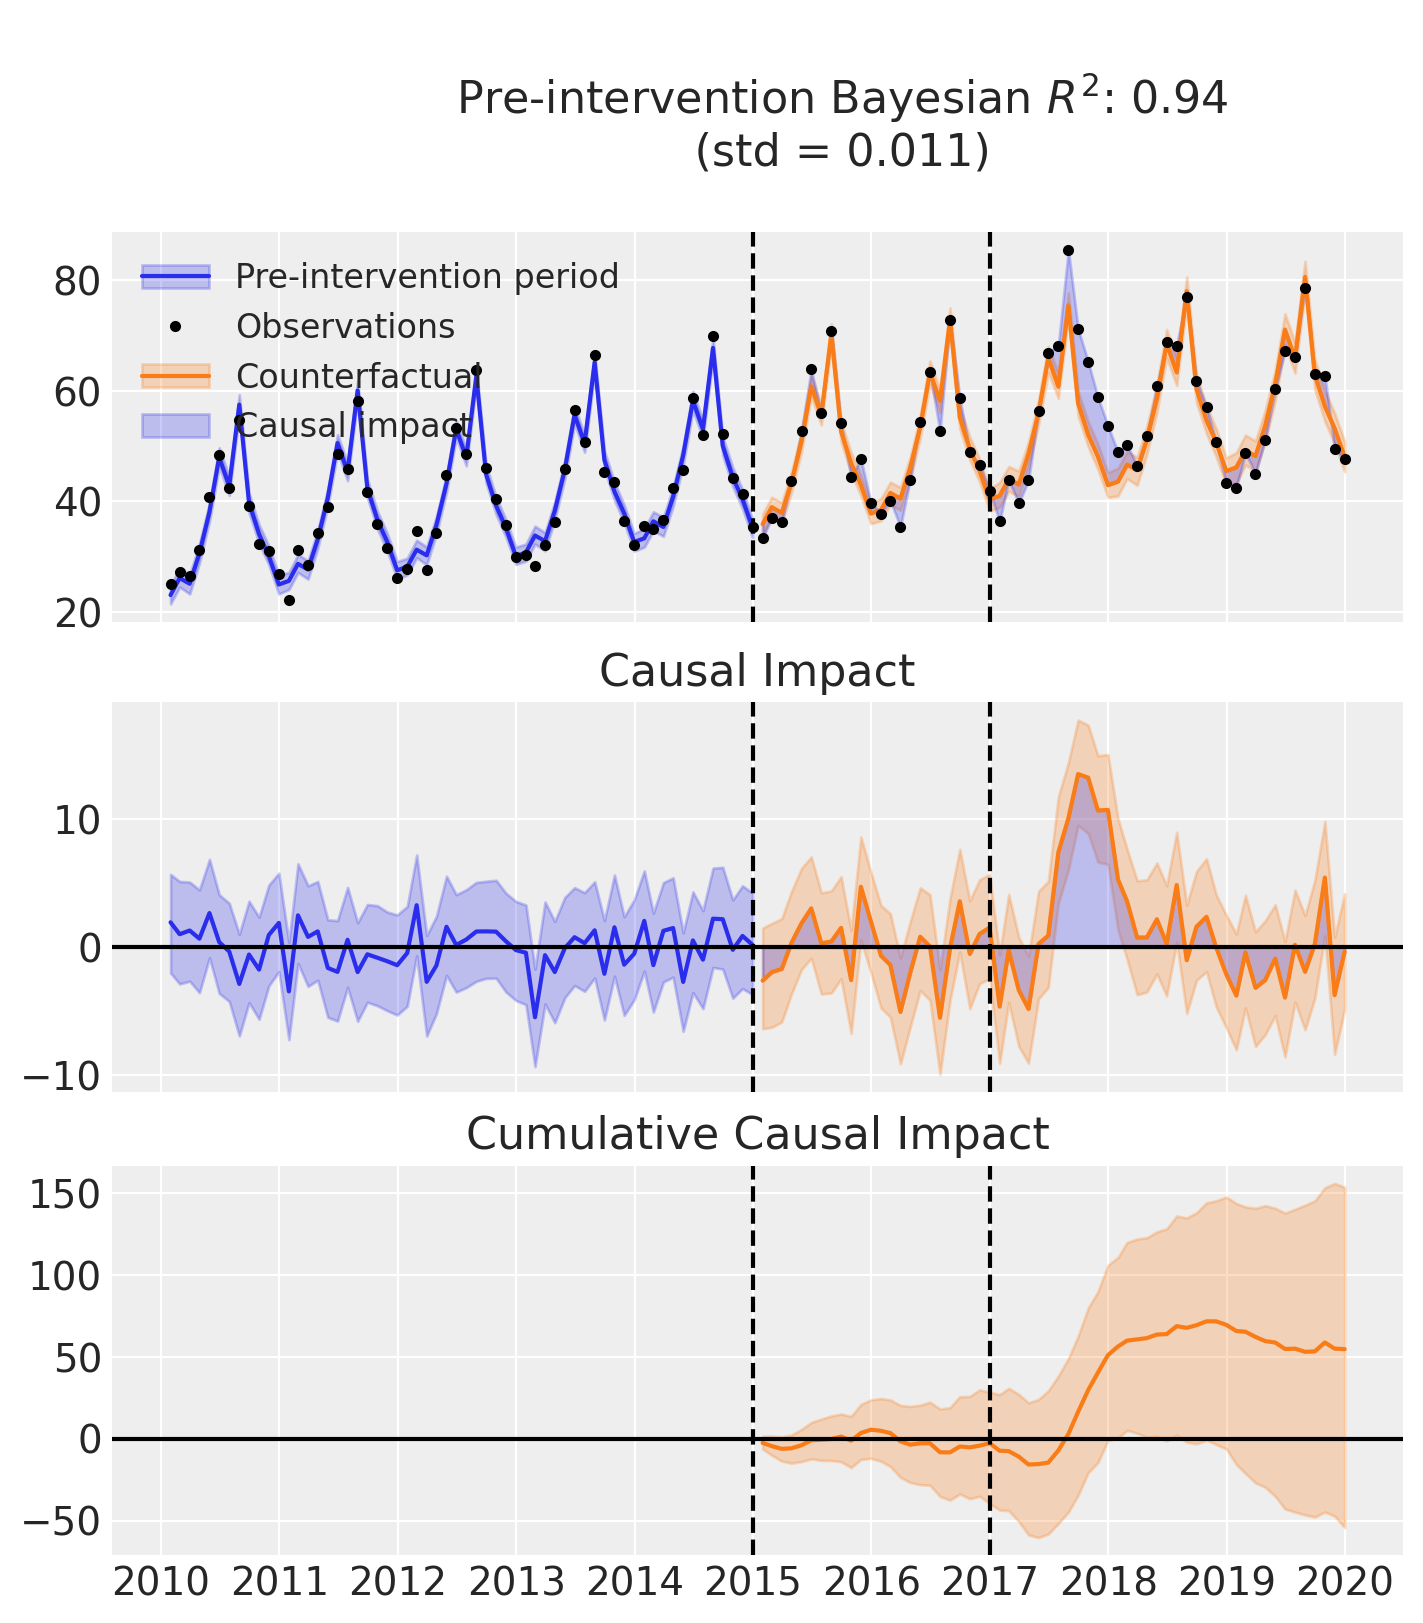

In [11]:
result.plot();

In [12]:
result.summary()

==================================Pre-Post Fit==================================
Formula: y ~ 1 + t + C(month)
Model coefficients:
    Intercept       23, 94% HDI [21, 25]
    C(month)[T.2]   2.9, 94% HDI [0.65, 5.1]
    C(month)[T.3]   1.6, 94% HDI [-0.65, 3.9]
    C(month)[T.4]   6.9, 94% HDI [4.7, 9.1]
    C(month)[T.5]   14, 94% HDI [12, 16]
    C(month)[T.6]   24, 94% HDI [22, 26]
    C(month)[T.7]   18, 94% HDI [16, 21]
    C(month)[T.8]   33, 94% HDI [31, 35]
    C(month)[T.9]   15, 94% HDI [13, 17]
    C(month)[T.10]  9.1, 94% HDI [7, 11]
    C(month)[T.11]  4.9, 94% HDI [2.7, 7.1]
    C(month)[T.12]  -0.44, 94% HDI [-2.7, 1.8]
    t               0.21, 94% HDI [0.19, 0.24]
    sigma           1.9, 94% HDI [1.6, 2.3]
